In [1]:
import tensorflow as tf
print(tf.__version__)

2.5.0


In [2]:
import numpy as np
import cv2
import tarfile
from pathlib import Path
from tqdm import tqdm
import shutil
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras import layers as tfl
from tensorflow.keras.layers import *
from tensorflow_addons.image import transform as H_transform
import matplotlib.pyplot as plt
import os, datetime

In [3]:
!pwd

/root/Internship-Valeo/Project


In [4]:
DATA_PATH = '/root/Internship-Valeo/Project/data/COCO'

In [5]:
from datasets.utils import pipeline
from datasets.utils.pipeline import parse_primitives
from datasets.utils import photometric_augmentation as photaug
from models.homographies import (sample_homography, compute_valid_mask,
                                            warp_points, filter_points)
from models.utils import box_nms

In [6]:
config = {
            'primitives': 'all',
            'truncate': {},
            'validation_size': -1,
            'test_size': -1,
            'on-the-fly': False,
            'cache_in_memory': False,
            'suffix': None,
            'add_augmentation_to_test_set': False,
            'num_parallel_calls': 10,
            'generation': {
                'split_sizes': {'training': 10000, 'validation': 200, 'test': 500},
                'image_size': [960, 1280],
                'random_seed': 0,
                'params': {
                    'generate_background': {
                        'min_kernel_size': 150, 'max_kernel_size': 500,
                        'min_rad_ratio': 0.02, 'max_rad_ratio': 0.031},
                    'draw_stripes': {'transform_params': (0.1, 0.1)},
                    'draw_multiple_polygons': {'kernel_boundaries': (50, 100)}
                },
            },
            'preprocessing': {
                'resize': [240, 320],
                'blur_size': 11,
            },
            'augmentation': {
                'photometric': {
                    'enable': True,
                    'primitives': 'all',
                    'params': {
                        'random_brightness': {'max_abs_change': 75},
                        'random_contrast': {'strength_range': [0.3, 1.8]},
                        'additive_gaussian_noise': {'stddev_range': [0, 15]},
                        'additive_speckle_noise': {'prob_range': [0, 0.0035]},
                        'additive_shade':{
                            'transparency_range': [-0.5, 0.8],
                            'kernel_size_range': [50, 100]},
                        'motion_blur': {'max_kernel_size': 7}},
                    'random_order': True,
                },
                'homographic': {
                    'enable': True,
                    'params': {
                        'translation': True,
                        'rotation': True,
                        'scaling': True,
                        'perspective': True,
                        'scaling_amplitude': 0.2,
                        'perspective_amplitude_x': 0.2,
                        'perspective_amplitude_y': 0.2,
                        'patch_ratio': 0.8,
                        'max_angle': 1.57,  # 3.14
                        'allow_artifacts': True,
                        'translation_overflow': 0.05,
                        'valid_border_margin': 2,
                    },
                    'valid_border_margin': 0,
                },
            }
    }

In [7]:
logdir = "logs/scalars/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

In [8]:
# code for photometric augmentation

primitives_photo = parse_primitives(config['primitives'], photaug.augmentations)

prim_configs = [config['augmentation']['photometric']['params'].get(p, {}) for p in primitives_photo]

indices = tf.range(len(primitives_photo))
if config['augmentation']['photometric']['random_order']:
    indices = tf.random.shuffle(indices)
def photo_aug_step(i, image):
    fn_pairs = [(tf.equal(indices[i], j), lambda p=p, c=c: getattr(photaug, p)(image, **c))
                for j, (p, c) in enumerate(zip(primitives_photo, prim_configs))]
    image = tf.case(fn_pairs)
    return i + 1, image

In [9]:
# read keypoints
def _read_points(filename):
    return np.load(filename).astype(np.float32)

In [10]:
model_config = {
            'data_format': 'channels_last',
            'grid_size': 8,
            'detection_threshold': 0.001, # 1/65
            'descriptor_size': 256,
            'batch_size': 32,
            'epochs': 25,
            'learning_rate': 0.001,
            'kernel_reg': 0.,
            'lambda_d': 250,
            'descriptor_size': 256,
            'positive_margin': 1,
            'negative_margin': 0.2,
            'lambda_loss': 0.0001,
            'nms': 4,
            'top_k': 0
    }

In [11]:
class DataGen(keras.utils.Sequence):
    def __init__(self, image_path, point_path, #homography_path, warped_image_path, warped_point_path,
                 is_training, batch_size = model_config['batch_size']):
        self.__ids = os.listdir(image_path)
        self.__image_path, self.__point_path = image_path, point_path
        
        
#         self.__homography_path = homography_path
#         self.__warped_image_path = warped_image_path
#         self.__warped_point_path = warped_point_path
        
        
        self.__batch_size = batch_size
        self.__is_training = is_training
        self.on_epoch_end()
        
    def __load__(self , id_name):
    
        image_path = os.path.join(self.__image_path , id_name)
        point_path = os.path.join(self.__point_path , id_name) + '.npy'
    
        image = cv2.imread(image_path , 0) # 1 specifies GreyScale format
        image = cv2.resize(image , (320 , 240)) # resizing before inserting to the network
        image = np.expand_dims(image, axis = 2)
        
        points = _read_points(point_path)
        points = np.round(points).astype(int)
    
        return image , points
        
    def __getitem__(self, index):
        images = []
        points_maps = []
        points_list = []
        homography_list = [] # not returned yet
        warped_images = []
        valid_masks = []
        warped_points_list = []
        warped_points_maps = []
        
        
        if (index + 1)*self.__batch_size > len(self.__ids):
            self.__batch_size = len(self.__ids) - index * self.__batch_size
        file_batch = self.__ids[index * self.__batch_size : (index + 1) * self.__batch_size]    
        
        for id_name in file_batch:
            image, points = self.__load__(id_name)
            image_shape = tf.shape(image)[:2]

            
#             homography_file = os.path.join(self.__homography_path, id_name) + '.npy'
#             homography = _read_points(homography_file)
#             warped_img_file = os.path.join(self.__warped_image_path, id_name)
#             warped_image = cv2.imread(warped_img_file, 0)
# #             warped_image = np.expand_dims(warped_image, axis = 2)
#             warped_point_file = os.path.join(self.__warped_point_path, id_name) + '.npy'
#             warped_points = _read_points(warped_point_file)
            
    
            if self.__is_training:
                # add photometric_augmentation
                _, image = tf.while_loop(lambda i, image: tf.less(i, len(primitives_photo)),
                                 photo_aug_step, [0, image], parallel_iterations=1)              
                
                # add homography
                homography = sample_homography(image_shape, config['augmentation']['homographic']['params'])[0]
                warped_image = H_transform(image, homography, interpolation='BILINEAR')
                valid_mask = compute_valid_mask(image_shape, homography,
                                         config['augmentation']['homographic']['valid_border_margin'])
                warped_points = warp_points(points, homography)
                warped_points = filter_points(warped_points, image_shape)
                warped_points = np.round(warped_points).astype(int)
                warped_kp = tf.minimum(warped_points, image_shape-1)
                warped_points_map = tf.scatter_nd(warped_points, tf.ones([tf.shape(warped_points)[0]], 
                                                                     dtype=tf.int32), image_shape)
                        
                homography_list.append(homography)
                warped_image = warped_image / 255.0
                warped_images.append(warped_image)
                valid_masks.append(valid_mask)
                warped_points_list.append(warped_points)
                warped_points_maps.append(warped_points_map)

            kp = tf.minimum(points, image_shape-1)
            points_map = tf.scatter_nd(kp, tf.ones([tf.shape(kp)[0]], dtype=tf.int32), image_shape)
            
            image = image / 255.0
            images.append(image)
            points_maps.append(points_map)
            points_list.append(points)
            
            
        images = np.array(images)
        points_maps = np.expand_dims(points_maps, axis = 3)
        points_maps = np.array(points_maps)
        if self.__is_training:
            warped_images = np.array(warped_images)
            warped_points_maps = np.expand_dims(warped_points_maps, axis = 3)
            warped_points_maps = np.array(warped_points_maps)
            valid_masks = np.array(valid_masks)
            dummy_loss_target = np.zeros(self.__batch_size)

            return [warped_images, valid_masks, warped_points_maps], [dummy_loss_target]
        
        else:
            return images, points_maps   
           
    def __len__(self):
        return int(np.ceil(len(self.__ids) / float(self.__batch_size)))
    
    def on_epoch_end(self):
        pass

In [12]:
def vgg_block(inputs, filters, kernel_size, name, data_format, training=False,
              batch_normalization=True, kernel_reg=0., **params):
    x = tfl.Convolution2D(filters, kernel_size, kernel_initializer='he_uniform',
                       kernel_regularizer=tf.keras.regularizers.L2(kernel_reg),
                       data_format=data_format, **params)(inputs)
    if batch_normalization:
        x = tfl.BatchNormalization(
                    fused=True,
                    axis=1 if data_format == 'channels_first' else -1)(x)
    return x

In [13]:
def shared_encoder(inputs, model_config):
    params_conv = {'padding': 'SAME', 'data_format': model_config['data_format'],
                   'batch_normalization': True,
                   'kernel_reg': model_config.get('kernel_reg', 0.)}
    cfirst = model_config['data_format'] == 'channels_first'
    cindex = 1 if cfirst else -1  # index of the channel
    pool_size=(2, 2)
    kernel = 3
    # Encoder
    conv1 = vgg_block(inputs, 64, (kernel, kernel), 'conv1_1', **params_conv)
    conv2 = vgg_block(conv1, 64, (kernel, kernel), 'conv1_2', **params_conv)
    pool1 = MaxPooling2D(pool_size, name="block1_pool")(conv2)

    conv3 = vgg_block(pool1, 64, (kernel, kernel), 'conv2_1', **params_conv)
    conv4 = vgg_block(conv3, 64, (kernel, kernel), 'conv2_2', **params_conv)
    pool2 = MaxPooling2D(pool_size, name="block2_pool")(conv4)

    conv5 = vgg_block(pool2, 128, (kernel, kernel), 'conv3_1', **params_conv)
    conv6 = vgg_block(conv5, 128, (kernel, kernel), 'conv3_2', **params_conv)
    pool3 = MaxPooling2D(pool_size, name="block3_pool")(conv6)

    conv7 = vgg_block(pool3, 128, (kernel, kernel), 'conv4_1', **params_conv)
    conv8 = vgg_block(conv7, 128, (kernel, kernel), 'conv4_2', **params_conv)
    return conv8

In [14]:
def detector_head(inputs, model_config):
    params_conv = {'padding': 'SAME', 'data_format': model_config['data_format'],
                   'batch_normalization': True,
                   'kernel_reg': model_config.get('kernel_reg', 0.)}
    cfirst = model_config['data_format'] == 'channels_first'
    cindex = 1 if cfirst else -1  # index of the channel

    x = vgg_block(inputs, 256, 3, 'conv1',
                      activation=tf.nn.relu, **params_conv)
    x = vgg_block(x, 1+pow(model_config['grid_size'], 2), 1, 'conv2',
                      activation=None, **params_conv)

    prob = tf.nn.softmax(x, axis=cindex)
    # Strip the extra “no interest point” dustbin
    prob = prob[:, :-1, :, :] if cfirst else prob[:, :, :, :-1]
    prob = tf.nn.depth_to_space(
              prob, model_config['grid_size'], data_format='NCHW' if cfirst else 'NHWC')
    prob = tf.squeeze(prob, axis=cindex)
    return {'logits': x, 'prob': prob}

In [15]:
def detector_loss(keypoint_map, logits, model_config, valid_mask=None):
    if model_config['data_format'] == 'channels_first':
        logits = tf.transpose(logits, [0, 2, 3, 1])
    # Convert the boolean labels to indices including the "no interest point" dustbin
    labels = keypoint_map#[..., tf.newaxis]  # for GPU
    labels = tf.cast(labels, tf.float32)
    labels = tf.nn.space_to_depth(labels, model_config['grid_size'])
    shape = tf.concat([tf.shape(labels)[:3], [1]], axis=0)
    labels = tf.concat([2*labels, tf.ones(shape)], 3)
    # Add a small random matrix to randomly break ties in argmax
    labels = tf.argmax(labels + tf.random.uniform(tf.shape(labels), 0, 0.1), axis=3)
    # Mask the pixels if bordering artifacts appear
    valid_mask = tf.ones_like(keypoint_map) if valid_mask is None else valid_mask
#     valid_mask = valid_mask[..., tf.newaxis]  # for GPU
    valid_mask = tf.cast(valid_mask, tf.float32)
    valid_mask = tf.nn.space_to_depth(valid_mask, model_config['grid_size'])
    valid_mask = tf.math.reduce_prod(valid_mask, axis=3)  # AND along the channel dim
    valid_mask = tf.cast(valid_mask, tf.int64)
#     labels = labels * valid_mask
#     loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=labels, logits=logits)
    loss = tf.compat.v1.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits, weights=valid_mask)
    return loss

In [16]:
def model_metrics(y_true, y_pred, valid_mask):
    if model_config['nms']:
        prob = tf.map_fn(lambda p: box_nms(p, model_config['nms'],
                                               min_prob=model_config['detection_threshold'],
                                               keep_top_k=model_config['top_k']), y_pred)
    pred = tf.cast(tf.greater_equal(prob, model_config['detection_threshold']), tf.float32)
    pred = tf.expand_dims(pred, axis = 3)
    pred = valid_mask * pred
    labels = y_true
    precision = tf.math.reduce_sum(pred * labels) / tf.math.reduce_sum(pred)
    recall = tf.math.reduce_sum(pred * labels) / tf.math.reduce_sum(labels)
#     return {'precision': precision, 'recall': recall}
    return precision

In [17]:
class DetectorLossLayer(Layer):
    def __init__(self, name='detector_loss_layer', trainable=False):
        super(DetectorLossLayer, self).__init__(name=name)
        self.loss_fn = detector_loss
        self.metrics_fn = model_metrics
    def call(self, inputs, targets=None, sample_weight=None):
        loss = self.loss_fn(inputs[0], inputs[1]['logits'], model_config = model_config, valid_mask = inputs[2])
        metrics = self.metrics_fn(inputs[0], inputs[1]['prob'], valid_mask = inputs[2])
        self.add_loss(tf.math.reduce_mean(loss))
        self.add_metric(metrics, name = 'precision')
        return loss
    def compute_output_shape(self, input_shape):
        return [1]

def net(input_shape = (240, 320, 1)):
    images_inputs = Input(shape = input_shape, name = 'images')
    valid_masks_inputs = Input(shape = input_shape, name = 'valid_masks')
    warped_points_inputs = Input(shape = input_shape, name = 'warped_points')
    
    encoder_output = shared_encoder(images_inputs, model_config=model_config)
    output = detector_head(encoder_output, model_config=model_config)
    
    loss_layer = DetectorLossLayer()([warped_points_inputs, output, valid_masks_inputs])
    
    model = keras.models.Model(inputs = [images_inputs, valid_masks_inputs, warped_points_inputs] , 
                               outputs = [loss_layer])
    return model

In [18]:
model = net(input_shape = (240, 320, 1))

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


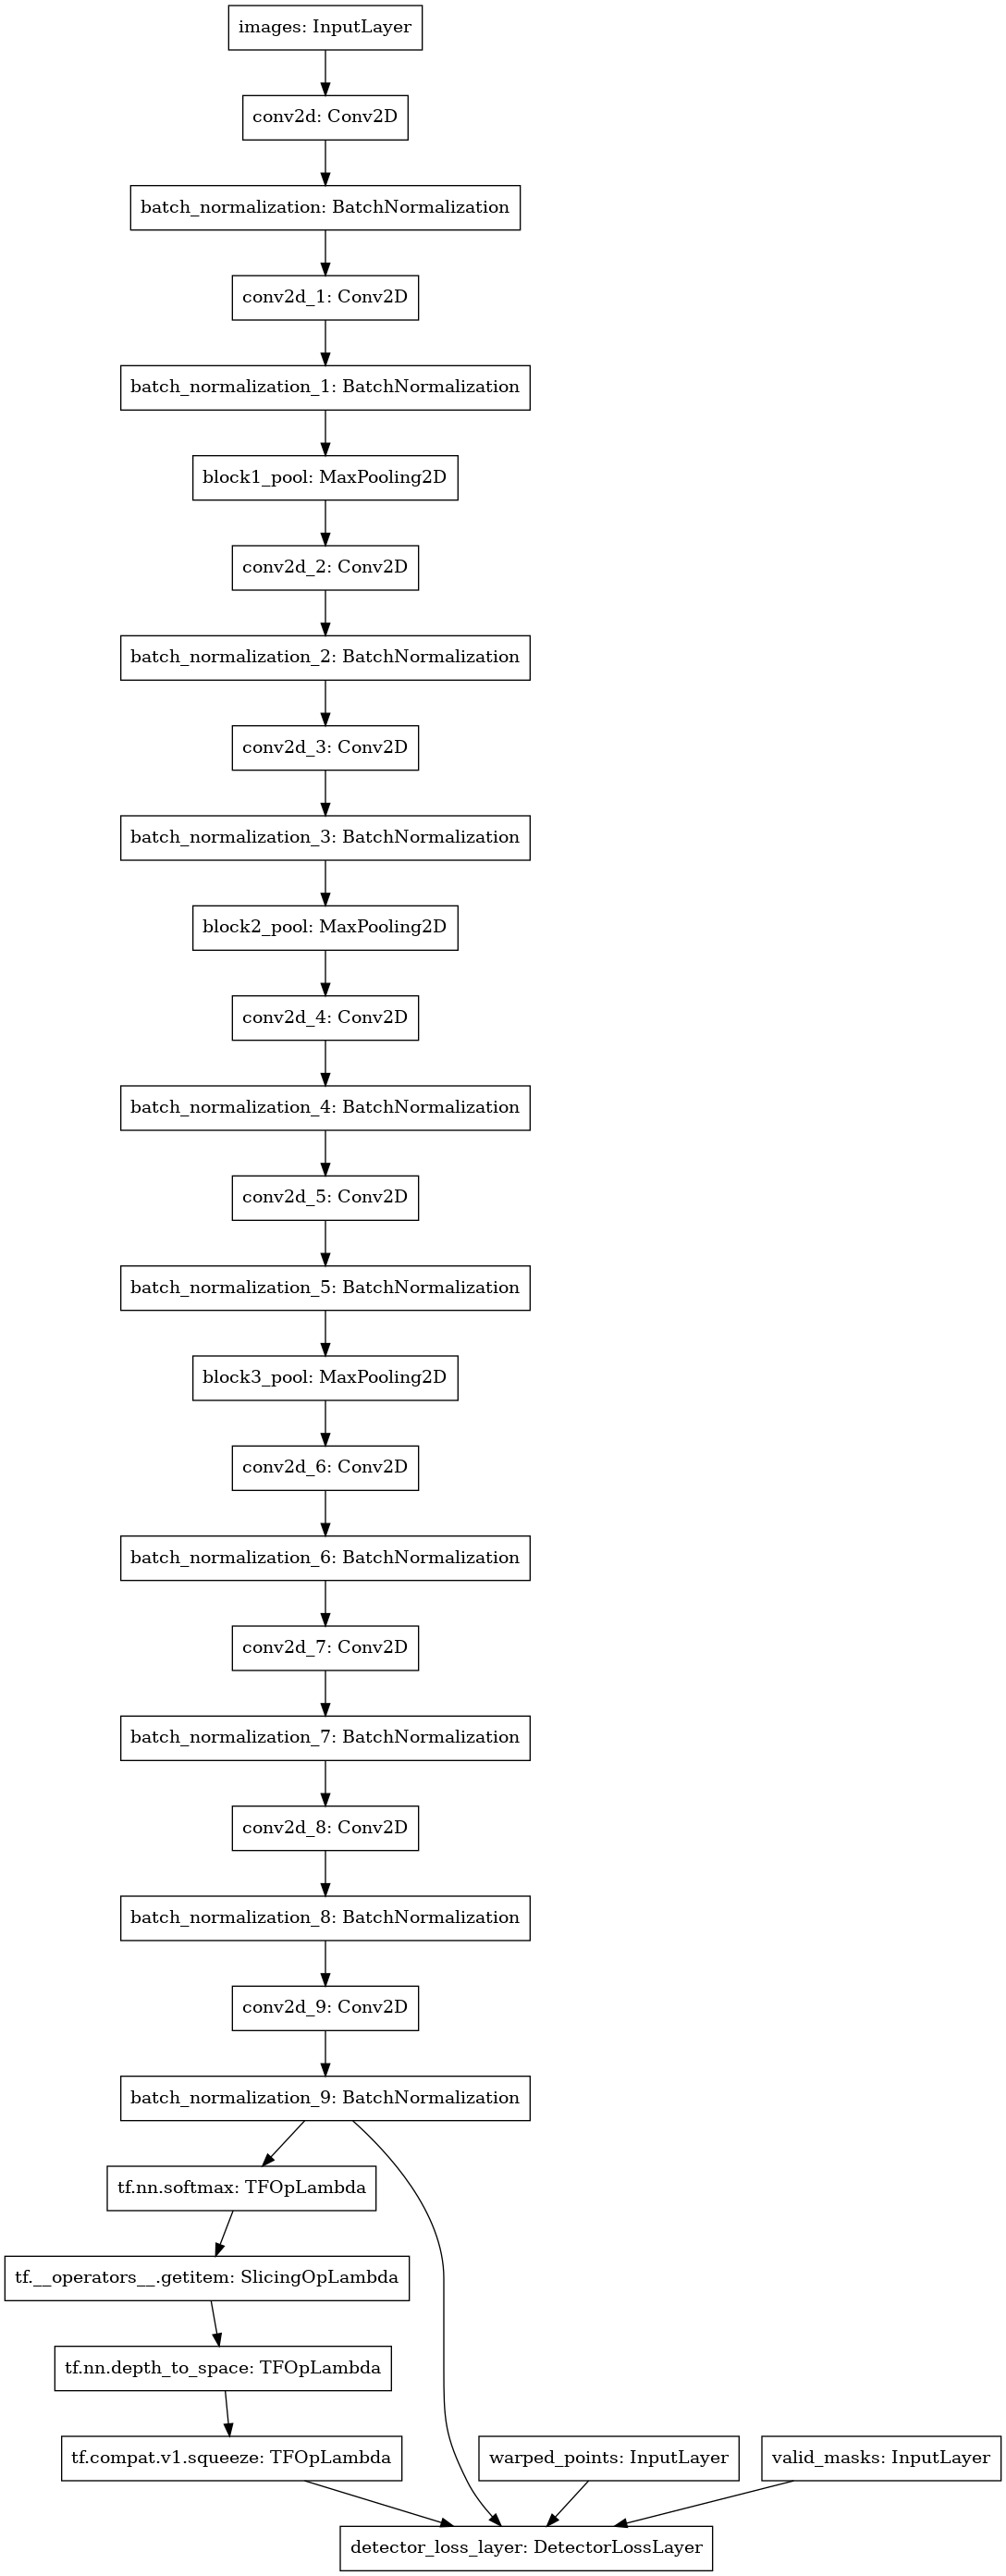

In [19]:
# model.summary()
keras.utils.plot_model(model, to_file="model.png", show_shapes=False, show_dtype=False, show_layer_names=True,
    rankdir="TB", expand_nested=False, dpi=96)

In [20]:
def dummy_loss(dummy_target, y_pred):
    return tf.squeeze(y_pred)

model.compile(optimizer = keras.optimizers.Adam(learning_rate = 1e-3),
              loss = dummy_loss)

In [21]:
batch_size = model_config['batch_size']

train_image_path = DATA_PATH + '/anntrain2014'
train_point_path = DATA_PATH + '/pointstrain2014'
# train_homography_path = DATA_PATH + '/homographies_train'
# train_warped_image_path = DATA_PATH + '/warptrain2014'
# train_warped_point_path = DATA_PATH + '/warped_pointstrain2014'
train_gen = DataGen(train_image_path, train_point_path, #train_homography_path, train_warped_image_path,
                #    train_warped_point_path, 
                    batch_size = batch_size, is_training = True)

val_image_path = DATA_PATH + '/annval2014'
val_point_path = DATA_PATH + '/pointsval2014'
# val_homography_path = DATA_PATH + '/homographies_val'
# val_warped_image_path = DATA_PATH + '/warpval2014'
# val_warped_point_path = DATA_PATH + '/warped_pointsval2014'
val_gen = DataGen(val_image_path, val_point_path, #val_homography_path, val_warped_image_path,
               #   val_warped_point_path, 
                  batch_size = batch_size, is_training = True)

train_steps =  len(os.listdir(train_image_path))/batch_size

In [36]:
history = model.fit(train_gen , validation_data = val_gen, steps_per_epoch = train_steps, 
                    epochs = model_config['epochs'], callbacks=[tensorboard_callback])

Epoch 1/25
1411/1411 [==============================] - 6388s 5s/step - loss: 3.9311 - precision: 0.0035 - val_loss: 2.7795 - val_precision: 0.0037
Epoch 2/25
1411/1411 [==============================] - 2973s 2s/step - loss: 1.6243 - precision: 0.0040 - val_loss: 1.6443 - val_precision: 0.0049
Epoch 3/25
1411/1411 [==============================] - 838s 594ms/step - loss: 1.3357 - precision: 0.0049 - val_loss: 1.3270 - val_precision: 0.0055
Epoch 4/25
1411/1411 [==============================] - 693s 491ms/step - loss: 1.2464 - precision: 0.0064 - val_loss: 1.2462 - val_precision: 0.0068
Epoch 5/25
1411/1411 [==============================] - 650s 460ms/step - loss: 1.2168 - precision: 0.0073 - val_loss: 1.4025 - val_precision: 0.0062
Epoch 6/25
1411/1411 [==============================] - 499s 353ms/step - loss: 1.2021 - precision: 0.0081 - val_loss: 1.2155 - val_precision: 0.0077
Epoch 7/25
1411/1411 [==============================] - 491s 348ms/step - loss: 1.2025 - precision: 0.00

In [37]:
# model.save('/root/Internship-Valeo/Project/results/checkpoint-magicpoint-coco')

INFO:tensorflow:Assets written to: /root/Internship-Valeo/Project/results/checkpoint-magicpoint-coco/assets


In [ ]:
# model.load_weights('/root/Internship-Valeo/Project/results/checkpoint-magicpoint-no_aug')

In [22]:
x, y = train_gen.__getitem__(0)

In [23]:
x[0].shape

(32, 240, 320, 1)

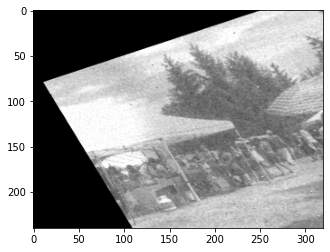

In [24]:
plt.imshow(x[0][31]*255, cmap = 'gray')

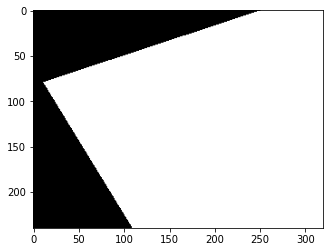

In [25]:
plt.imshow(x[1][31], cmap = 'gray')

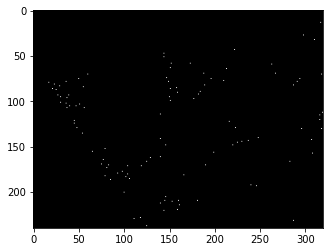

In [26]:
plt.imshow(x[2][31],cmap = 'gray')

In [27]:
y

[array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])]

In [28]:
x, y = val_gen.__getitem__(1)

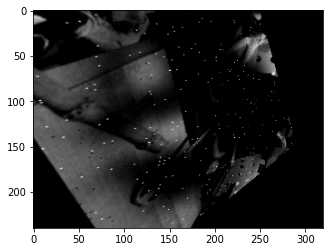

In [29]:
plt.imshow(x[0][0]*255, cmap = 'gray')

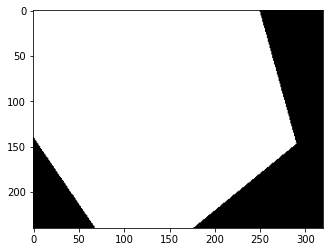

In [30]:
plt.imshow(x[1][0], cmap = 'gray')

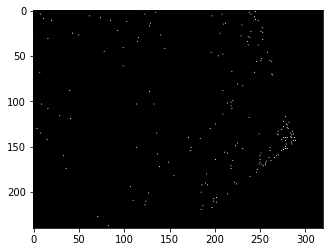

In [31]:
plt.imshow(x[2][0],cmap = 'gray')

In [38]:
result = model(x)

In [39]:
tf.math.reduce_mean(result)

<tf.Tensor: shape=(), dtype=float32, numpy=0.55588716>

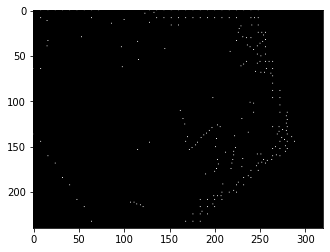

In [40]:
prob = model.get_layer('tf.compat.v1.squeeze').output
m = keras.models.Model(inputs = model.input, outputs = prob)

y_pred = m.predict(x)

model_config['top_k'] = 0
model_config['detection_threshold'] = 0.015

if model_config['nms']:
    prob = tf.map_fn(lambda p: box_nms(p, model_config['nms'],
                                               min_prob=model_config['detection_threshold'],
                                               keep_top_k=model_config['top_k']), y_pred)
    pred = tf.cast(tf.greater_equal(prob, model_config['detection_threshold']), tf.float32)
    
pred = pred * x[1] # multiplied with valid masks

plt.imshow(pred[0], cmap = 'gray')

In [44]:
y_pred.shape

(32, 240, 320)